In [1]:
#Cell 1 - Import Libraries & Setup Paths

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# Append project root to sys.path (if needed)
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

# Define directories for outputs
figures_dir = "../reports/figures"
text_dir = "../reports/text"
processed_dir = "../data/processed"

os.makedirs(figures_dir, exist_ok=True)
os.makedirs(text_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)


In [2]:
#Cell 2 - Load Processed Data
# Load the feature-engineered and encoded dataset

data_path = os.path.join(processed_dir, "train_feature_engineered_encoded.csv")
df = pd.read_csv(data_path)
print("Processed data loaded. Shape:", df.shape)

# Save a sample of the data for reference
sample_path = os.path.join(text_dir, "ensemble_data_sample.csv")
df.head(10).to_csv(sample_path, index=False)


Processed data loaded. Shape: (1399, 112)


In [3]:
#Cell 3 - Prepare Features and Target, Split Data
# Use only numeric columns to avoid conversion issues

numeric_df = df.select_dtypes(include=['number'])

# Ensure 'SalePrice' is the target
if 'SalePrice' not in numeric_df.columns:
    raise ValueError("Target column 'SalePrice' not found.")

y = numeric_df['SalePrice']
X = numeric_df.drop(columns=['SalePrice', 'Id'], errors='ignore')  # Drop 'Id' if exists

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (1119, 69)
Validation set shape: (280, 69)


In [4]:
#Cell 4 - Define Ensemble Model using StackingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define base estimators
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
]

# Define final estimator (meta-model)
final_estimator = Ridge(alpha=1.0)

# Create the stacking regressor ensemble model
ensemble_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

print("Ensemble model defined.")


Ensemble model defined.


In [5]:
#Cell 5 - Train Ensemble Model and Evaluate Performance
# Fit the ensemble model on the training data

ensemble_model.fit(X_train, y_train)
print("Ensemble model trained.")

# Generate predictions on the validation set
y_val_pred = ensemble_model.predict(X_val)

# Compute RMSE
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Ensemble Model Validation RMSE: {val_rmse:.2f}")

# Save evaluation result to text file
ensemble_eval_path = os.path.join(text_dir, "ensemble_validation_evaluation.txt")
with open(ensemble_eval_path, "w") as f:
    f.write(f"Ensemble Model Validation RMSE: {val_rmse:.2f}\n")
print("Ensemble model evaluation saved.")


Ensemble model trained.
Ensemble Model Validation RMSE: 19354.04
Ensemble model evaluation saved.


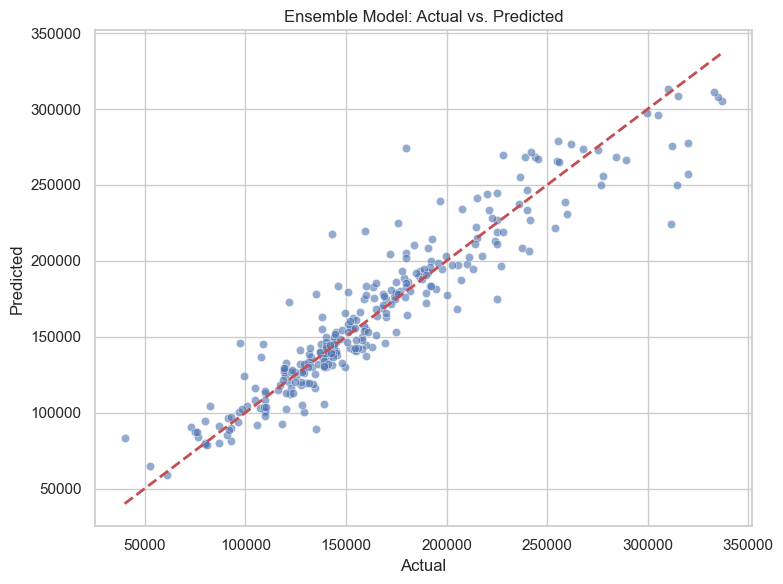

In [6]:
#Cell 6 - Visualize Actual vs. Predicted for Ensemble Model
# Import visualization function from evaluation module

from src.evaluation import plot_actual_vs_predicted

ensemble_plot_path = os.path.join(figures_dir, "ensemble_actual_vs_predicted.png")
plot_actual_vs_predicted(y_val, y_val_pred, title="Ensemble Model: Actual vs. Predicted", save_path=ensemble_plot_path)


In [7]:
#Cell 7 - Save Trained Ensemble Model

from src.models import save_model

ensemble_model_path = os.path.join(processed_dir, "ensemble_model.pkl")
save_model(ensemble_model, ensemble_model_path)


Model saved to ../data/processed/ensemble_model.pkl
